# Supercritical pitchfork bifurcation of a column
This notebook shows the calculation of the supercritical pitchfork bifurcation of a pin-ended column loaded in compression with MSC Nastran SOL 106 and SOL 400. We first recall the analytical results for a 1 DOF system and then we move on to the numerical computation.

* [1 DOF system](#1dof)
* [Numerical model](#numerical-model)
* [Subcases definition](#subcases-definition)
* [SOL 106](#sol106)
    * [Full Newton method](#newton)
    * [Arc-length method](#arc-length)
        * [Alternative subcase sequence](#alternative-subcase)
    * [Mixed methods](#mixed-methods)
* [SOL 400](#sol400)

## 1 DOF system <a name="1dof"></a>
Let's take the 1 DOF system represented below, composed by two initially collinear rods with a linear torsional spring under axial compressive load $P$.

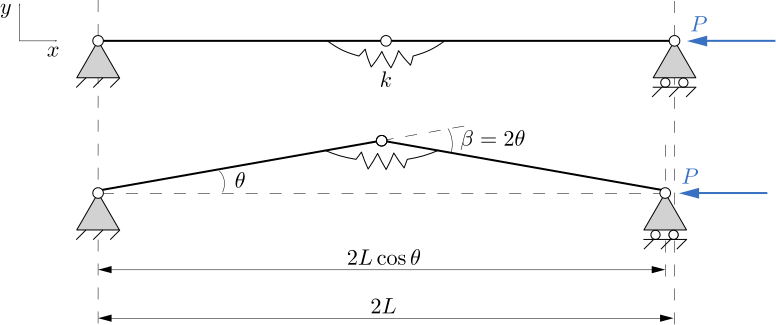

In [296]:
from IPython.display import SVG
SVG(filename='CollinearRods.svg')

The equilibrium equation is satisfied under two conditions:
$$\theta=0$$
$$\frac{P}{P_{cr}}=\frac{\theta}{\sin\theta}$$
where $\theta=0$ is the trivial solution and $P_{cr}=2k/L$ is the buckling load.

For $\theta=0$ the equilibrium is stable for $P<P_{cr}$, while for $P/P_{cr}=\theta/\sin\theta$ the equilibrium is always stable.

If we add an imperfection to the system, like the initial angle $\theta_0$ shown below, the equilibrium changes.

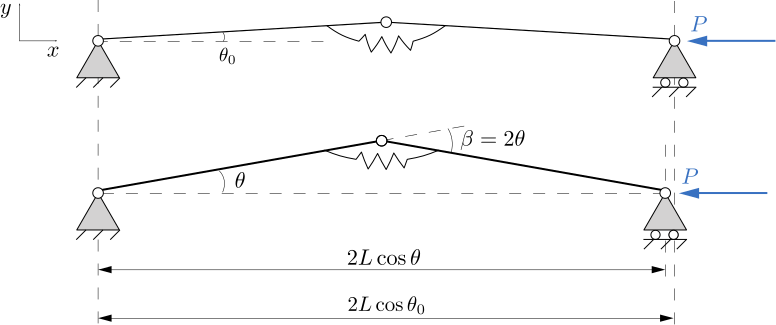

In [297]:
SVG(filename='ImperfectionRods.svg')

The symmetry of the problem is broken and the equilibrium is found for the following condition:
$$\frac{P}{P_{cr}}=\frac{\theta-\theta_0}{\sin\theta}$$

If we plot the results we can observe the supercritical pitchfork bifurcation and the broken pitchfork.

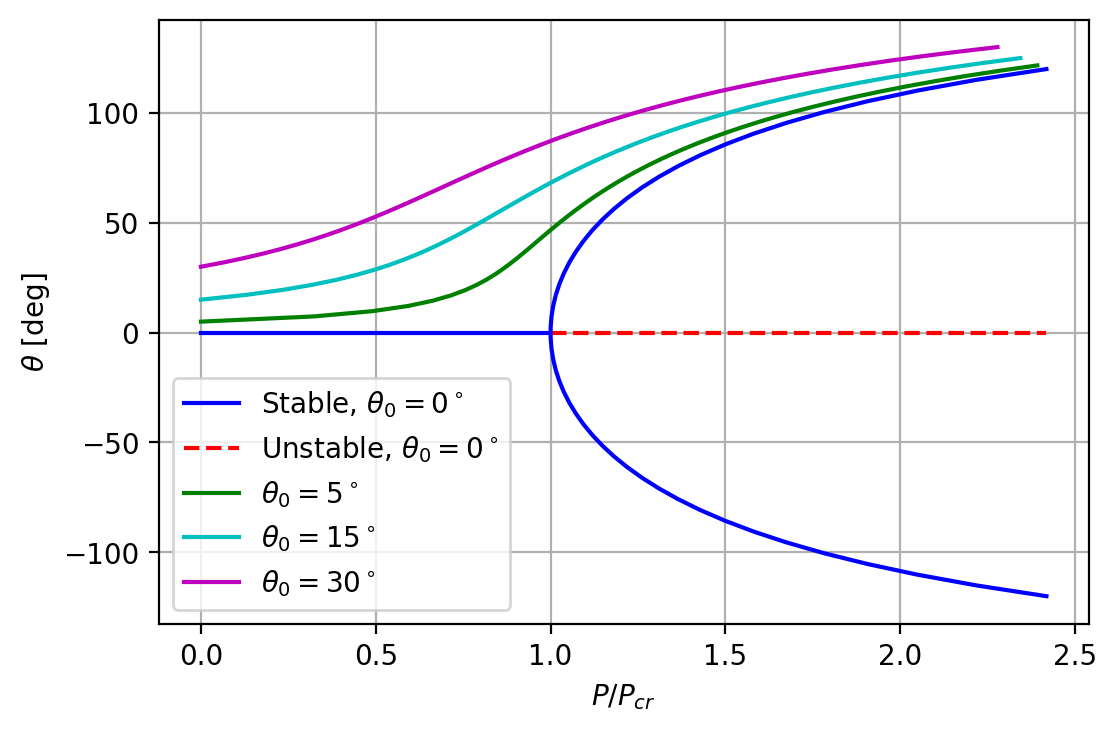

In [298]:
# Import matplotlib
import matplotlib.pyplot as plt
# Render static images
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
# Render interactive figures
# %matplotlib notebook
# Create figure
fig, ax = plt.subplots()

# Perfect system
import numpy as np
theta_trivial_stable = np.array([0., 0.])  # deg
load_trivial_stable = np.array([0., 1.])
theta_stable = np.linspace(-120, 120)  # deg
load_stable = np.deg2rad(theta_stable)/np.sin(np.deg2rad(theta_stable))
theta_trivial_unstable = np.array([0., 0.])  # deg
load_trivial_unstable = np.array([1., np.max(load_stable)])
style = {'stable': '-b', 'unstable': '--r'}
ax.plot(load_trivial_stable, theta_trivial_stable, style['stable'], label='Stable, $\\theta_0 = 0^\circ$')
ax.plot(load_trivial_unstable, theta_trivial_unstable, style['unstable'], label='Unstable, $\\theta_0 = 0^\circ$')
ax.plot(load_stable, theta_stable, style['stable'])

# Imperfection
imperfections = [5, 15, 30]  # deg
style = {5: '-g', 15: '-c', 30: '-m'}
for theta_0 in imperfections:
    theta_imperfection = np.linspace(theta_0, 120 + theta_0/3)
    load_imperfection = (np.deg2rad(theta_imperfection-theta_0))/np.sin(np.deg2rad(theta_imperfection))
    ax.plot(load_imperfection, theta_imperfection, style[theta_0], label='$\\theta_0={:d}^\circ$'.format(theta_0))

# Set plot appearance
ax.set_xlabel('$P/P_{cr}$')
ax.set_ylabel('$\\theta$ [deg]')
ax.legend()
ax.grid()
plt.show()

## Numerical model <a name="numerical-model"></a>
We consider a constant cross-sectional column with the following characteristics (inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539)):
 * Young's modulus $E=207$ GPa
 * Poisson's ratio $\nu=0.3$
 * density $\rho=7.8\cdot10^{-4}$ tons/mm$^3$
 * diameter $d=20$ mm
 * length $l=420$ mm

The shear modulus $G$ will be calculated by Nastran according to the following equation:
$$E=2(1+\nu)G.$$

We discretize the column into 420 beam elements and we consider a two-dimensional problem in the $xy$ plane, so permanent single-point constraints for all nodes are enforced for the corresponding degrees of freedom. For the boundary conditions we define two single-point constraints: a pin support at one end of the column and a roller support at the other end.

With the mentioned input variables we call the `create_column_base_model` function, which returns a `BDF` object with our base model. Finally, we define the name of our model.

In [299]:
import utils
E = 207000.  # [MPa]
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
d = 20  # [mm]
l = 420  # [mm]
no_elements = 420
model = utils.create_column_base_model(E, nu, rho, d, l, no_elements)

subcase=0 already exists...skipping


Let's visualize some information about the model that we have just created.

In [300]:
print(model.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcadds[3]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.params
  PARAM    : 2

bdf.nodes
  GRID     : 421

bdf.elements
  CBEAM    : 420

bdf.properties
  PBEAML   : 1

bdf.materials
  MAT1     : 1




Before moving on to the definition of the subcases, we calculate the buckling load using Euler's formula, so that we can nondimensionalize our results later.

In [301]:
I = np.pi*d**4/64  # [mm^4]
euler_buckling_load = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {euler_buckling_load:.2f} N')

Euler's buckling load: 90962.29 N


## Subcases definition <a name="subcases-definition"></a>
In order to reproduce the supercritical pitchfork bifurcation with our numerical model, we need to obtain the stable branch up to the buckling load, the unstable branch beyond the buckling load and one of the two symmetrical stable branches beyond the buckling load. In addition, we also want to visualize the broken pitchfork, in order to notice the influence of an initial imperfection or of an eccentricity in the oad. The approach to numerically reproduce the supercritical pitchfork bifurcation as described is to use the following succession of subcases.

1. Apply a compression load larger than the buckling load at the roller-supported end of the column. Initially this will move us along the straight stable branch of the pitchfork and as the load increases we will move on to the unstable branch.

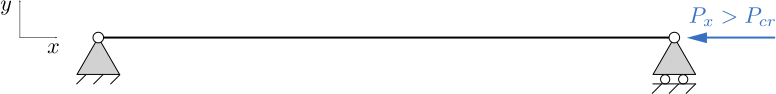

In [302]:
SVG(filename='Subcase1.svg')

2. Add a small transverse load at the middle of the column. This will break the symmetry of the problem and consequently the pitchfork, producing a certain deflection of the column.

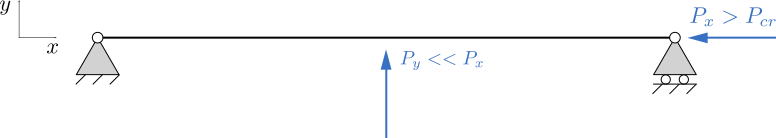

In [303]:
SVG(filename='Subcase2.svg')

3. Remove the transverse load in order to restore the symmetry of the problem. At this point also the pitchfork will be restored and the column will move onto the stable branch corresponding to the direction of the tranverse load that was applied in the previous subcase. As a consequence it will still be possible to observe a nonzero deflection of the column.

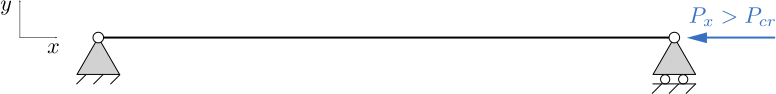

In [304]:
SVG(filename='Subcase1.svg')

4. Remove the compression load. This will move us along the curved stable branch until we get back to the straight stable branch and we sweep it back to the undeformed state of the column.

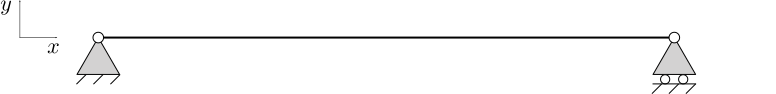

In [305]:
SVG(filename='Subcase4.svg')

5. Apply both the compression and the transverse load at the same time. This will let us visualize the equilibrium path of the broken pitchfork.

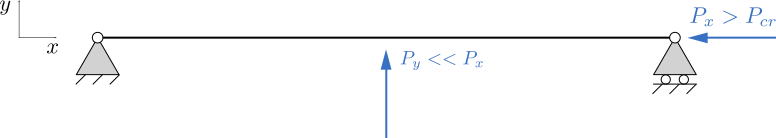

In [306]:
SVG(filename='Subcase2.svg')

Let's start by choosing a name for our model.

In [307]:
model_name = 'column_pitchfork_bifurcation'

 Then we define the compression force and the transverse force, which we will later assign to the different load sets. We consider a compression force equal to twice the Euler buckling load, $P_x/P_{cr}=2$ while we set the transverse force as a fraction of the buckling load $P_y/P_{cr}=1/100$.

In [308]:
# Compression force definition
compression_force_sid = list(model.spcadds.keys())[0]+1
last_node_id = no_elements+1
compression_force_magnitude = euler_buckling_load*2
compression_force_direction = [-1., 0., 0.]
model.add_force(sid=compression_force_sid, node=last_node_id, mag=compression_force_magnitude, xyz=compression_force_direction)
# Transverse force definition
transverse_force_sid = compression_force_sid+1
middle_node_id = int(no_elements/2+1)
transverse_force_magnitude = euler_buckling_load/100
transverse_force_direction = [0., 1., 0.]
model.add_force(sid=transverse_force_sid, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

FORCE          5     211        909.6229      0.      1.      0.

Let's define the first subcase and the corresponding load set, which includes only the compression force $P_x$.

In [309]:
subcase_id = 1
subtitle = 'Apply compression load'
compression_load_sid = transverse_force_sid+1
force_sids = [compression_force_sid]
scale_factors = [1.]
utils.create_column_subcase(model, subcase_id, subtitle, compression_load_sid, force_sids, scale_factors)

We proceed with the second subcase, where we add the transverse force $P_y$.

In [310]:
subcase_id = 2
subtitle = 'Add transverse load'
combined_load_sid = compression_load_sid+1
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., 1.]
utils.create_column_subcase(model, subcase_id, subtitle, combined_load_sid, force_sids, scale_factors)

We then define the third subcase, where we remove the transverse force $P_y$.

In [311]:
subcase_id = 3
subtitle = 'Remove transverse load'
model.create_subcases(subcase_id)
model.case_control_deck.subcases[subcase_id].add('SUBTITLE', subtitle, [], 'STRING-type')
model.case_control_deck.subcases[subcase_id].add_integer_type('LOAD', compression_load_sid)

Now we define the fourth subcase, where we remove also the compression force $P_x$.

In [312]:
subcase_id = 4
subtitle = 'Remove compression load'
zero_load_sid = combined_load_sid+1
force_sids = [compression_force_sid]
scale_factors = [0.]
utils.create_column_subcase(model, subcase_id, subtitle, zero_load_sid, force_sids, scale_factors)

Finally we define the fifth subcase, where we apply both the compression and the transverse load together.

In [313]:
subcase_id = 5
subtitle = 'Apply compression and transverse load'
model.create_subcases(subcase_id)
model.case_control_deck.subcases[subcase_id].add('SUBTITLE', subtitle, [], 'STRING-type')
model.case_control_deck.subcases[subcase_id].add_integer_type('LOAD', combined_load_sid)

## SOL 106 <a name="sol106"></a>
### Full Newton method <a name="newton"></a>
We choose SOL 106 as solution sequence and we set the parameters for the nonlinear iteration strategy to use the full Newton method. For this purpose, we define a `NLPARM` card with the following parameters:
* `ninc=100` to set the number of load increments
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration
* `max_iter=25` to set the maximum number of iterations for each load increment
* `conv='PV'` to select convergence criteria based on load equilibrium error with vector component method
* `int_out='YES'` to process the output for every computed load increment
* `eps_p=1e-3` to set the error tolerance for the load criteria
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment

We assign the id of the `NLPARM` card as default for all subcases.

In [314]:
model.sol = 106
nlparm_id = 1
model.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
model.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

We also need to define the additional parameter `PARAM,LGDISP,1` to assume all nonlinear structural element types with large displacement capability to have large displacement effects.

In [315]:
model.add_param('LGDISP', [1])

PARAM     LGDISP       1

Now let’s create an appropriate directory where we can run the analysis and let’s write our BDF object to an actual bdf file. Successively, we run the analysis with Nastran.

In [316]:
import os
from pyNastran.utils.nastran_utils import run_nastran
def run_analysis(directory_path, bdf_filename, bdf_object, run_flag):
    # Create analysis directory
    os.makedirs(directory_path, exist_ok=True)
    # Write bdf file
    output_bdf_file_path = os.path.join(directory_path, bdf_filename + '.bdf')
    bdf_object.write_bdf(output_bdf_file_path)
    # Run Nastran
    nastran_path = 'C:\\Program Files\\MSC.Software\\MSC_Nastran\\2021.4\\bin\\nastranw.exe'
    run_nastran(output_bdf_file_path, nastran_path, run_in_bdf_dir=True, run=run_flag)
    if run_flag:
        utils.wait_nastran(directory_path)

# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationFullNewtonMethod'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
run_analysis(analysis_directory_path, model_name, model, run_flag=False)

Once the analysis is done, we can read the op2 file and look for the load step, the rotation $\theta$ at the pin-supported node (having ID=1) and the applied load along $x$ and $y$ for every subcase and every nonlinear iteration step.

In [317]:
from pyNastran.op2.op2 import read_op2
def op2_to_output_data(op2_filename):
    # Read op2 file
    op2 = read_op2(op2_filename, build_dataframe=True, debug=False)
    # Store load step, rotation at the pin-supported node and applied load along x and y for each increment of each subcase
    node_id = 1
    load_step = {}
    theta = {}
    P_x = {}
    P_y = {}
    for subcase_id in op2.load_vectors:
        load_step[subcase_id] = op2.load_vectors[subcase_id].lftsfqs
        theta[subcase_id] = np.rad2deg(op2.displacements[subcase_id].data[:, node_id, 5])
        # We add a minus sign so that P_x is positive along the direction defined in the sketches
        P_x[subcase_id] = -np.apply_along_axis(np.sum, 1, op2.load_vectors[subcase_id].data[:, :, 0])
        P_y[subcase_id] = np.apply_along_axis(np.sum, 1, op2.load_vectors[subcase_id].data[:, :, 1])
    # Return output data
    return load_step, theta, P_x, P_y

# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)

We can now plot the results of our analysis. For each converged iteration of each subcase we plot:
 * load step versus $\theta$
 * applied load along $x$ versus $\theta$
 * applied load along $y$ versus $\theta$

In addition we print the value of $\theta$ at the end of each subcase.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = 124.34 degrees
Subcase 3: theta = 124.39 degrees
Subcase 4: theta = 0.00 degrees
Subcase 5: theta = 124.34 degrees


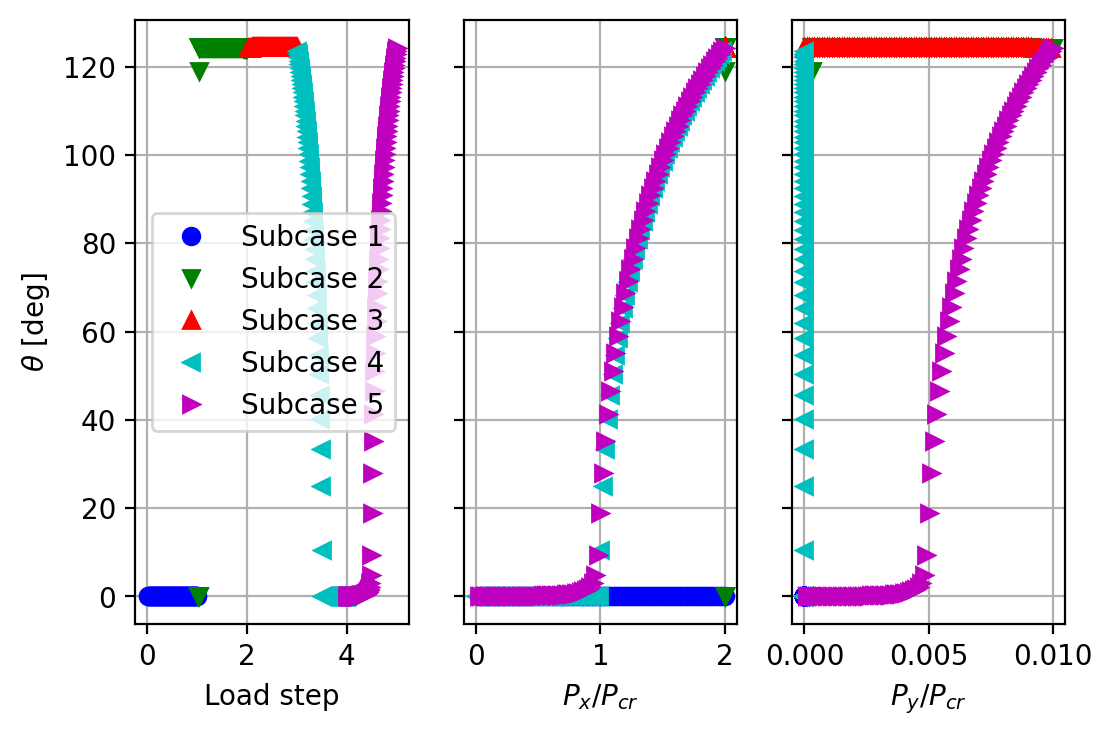

In [318]:
def plot_2d_paths(theta, load_step, P_x, P_y):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m'}
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in theta:
        # Print rotation at the end of subcase
        print(f'Subcase {subcase_id:d}: theta = {rotation[subcase_id][-1]:.2f} degrees')
        # Plot load step vs rotation
        axs[0].plot(load_step[subcase_id], theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs rotation
        axs[1].plot(P_x[subcase_id]/euler_buckling_load, theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along y vs rotation
        axs[2].plot(P_y[subcase_id]/euler_buckling_load, theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$\\theta$ [deg]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$P_x/P_{cr}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_y/P_{cr}$')
    axs[2].grid(visible=True)
    axs[0].legend()
    # Show plot
    plt.show()

plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)

The following can be observed for the different subcases.
* During the first subcase the rotation $\theta$ is always null. We first move along the stable branch of the equilibrium diagram ($P_x/P_{cr}<1$) and then along the unstable branch ($P_x/P_{cr}>1$).
* In subcase 2, $\theta$ jumps from zero to about 124 degrees, moving from the unstable branch to a point laying on the broken pitchfork corresponding to the value of transverse force applied.
* During the third subcase we move from the broken pitchfork to a point on the curved stable branch of the equilibrium diagram. Unexpectedly, at the end of the subcase $\theta$ is slightly smaller with respect to the value at the end of subcase 2. This is in contrast with the results of the 1 DOF system, where the imperfect structure always shows a larger value of $\theta$ for the same applied load $P_x/P_{cr}$.
* In subcase 4, we move along the curved stable branch as the column is unloaded and for $P_x/P_{cr}<1$ we traverse the flat stable branch until we get back to a null rotation.
* Finally, during subcase 5 the column is loaded with both the compression and the transverse force and we can observe the equilibrium path corresponding to the broken pitchfork. In particular, it is evident how the path of the broken pitchfork deviates from the one of the "pristine" pitchfork for $P_x/P_{cr}<1$. The final value of $\theta$ corresponds to the one obtained for the second subcase.

We can also plot the equilibrium diagram in 3D, adding $P_y/P_{cr}$ as $z$ axis.

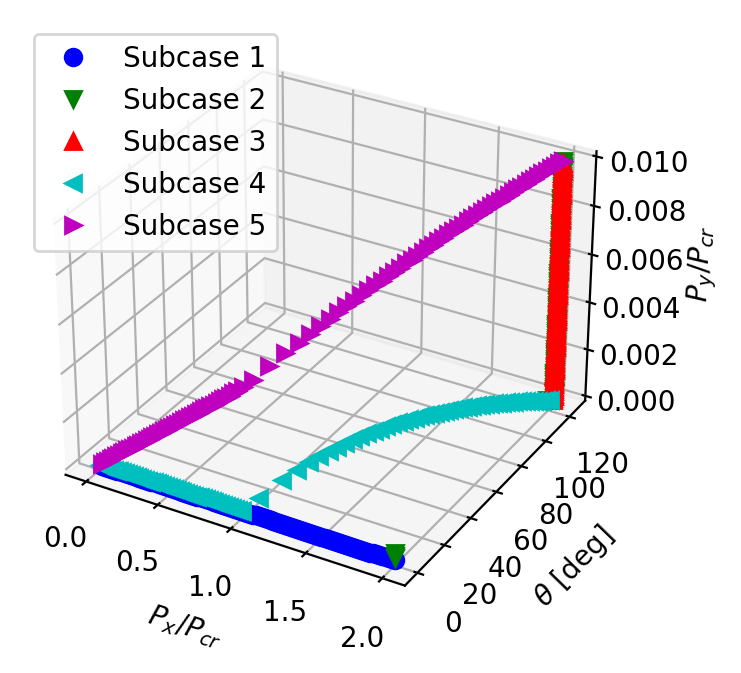

In [319]:
from mpl_toolkits import mplot3d
def plot_3d_paths(theta, P_x, P_y):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m'}
    # Create figure with three-dimensional axes
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for subcase_id in rotation:
        # Plot load applied along x vs rotation of pin-supported node vs applied along y
        ax.plot3D(P_x[subcase_id]/euler_buckling_load, theta[subcase_id], P_y[subcase_id]/euler_buckling_load, style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    ax.set_xlabel('$P_x/P_{cr}$')
    ax.set_ylabel('$\\theta$ [deg]')
    ax.set_zlabel('$P_y/P_{cr}$')
    ax.legend()
    ax.grid(visible=True)
    plt.show()

plot_3d_paths(rotation, applied_load_x, applied_load_y)

Here we can recognize equilibrium path of the classical supercritical pitchfork bifurcation on the $P_x/P_{cr}-\theta$ plane and the jump of $\theta$ during subcase 2. Furthermore, the 3D view enables the observation of two features.
* The path of the broken pitchfork is actually three-dimensional when we also consider the transverse load as an independent parameter of the system.
* The "pristine" and the broken pitchfork are connected by the equilibrium path found in subcase 3.

### Arc-length method <a name="arc-length"></a>
Now we try to obtain the same results using the arc-length incremental solution strategy. For this purpose we define a `NLPCI` card with the following parameters.
* `Type='CRIS'` to set Crisfield constraint type.
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point.
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment).
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase.

In [320]:
model.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)

NLPCI          1    CRIS     .01     1.1      0.               5    2000

We create the analysis directory, write the bdf file and run the analysis with Nastran.

In [321]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
run_analysis(analysis_directory_path, model_name, model, run_flag=False)

Analogously to the full Newton method case, we read the op2 file and we store the load step, the rotation $\theta$ and the applied load along $x$ and $y$ for every subcase and every iteration step. Successively, we plot the results in the same way as we did previously.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -3.51 degrees
Subcase 3: theta = 0.00 degrees
Subcase 4: theta = -76.58 degrees


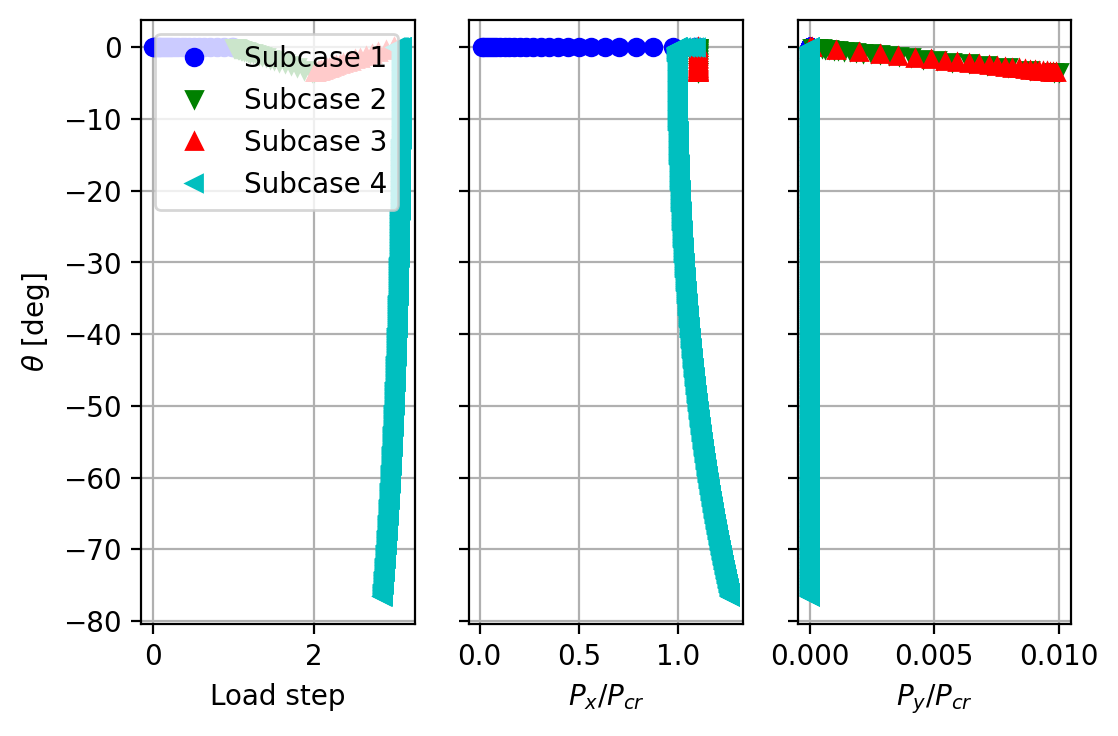

In [322]:
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)

We can easily observe some differences with respect to the full Newton method case.
* Only the equilibrium path of the broken pitchfork is obtained, while the "pristine" pitchfork is not captured. More in particular, we are able to traverse the straight stable and unstable branches, but we fail to switch to the desired branch during subcase 2.
* The value of $\theta$ at the end of the second subcase is slightly negative. This appears to be counterintuitive, as it means that the column is deflecting towards the opposite direction with respect to the one of the applied transverse load.

Also in this case we can plot the equilibrium diagram in 3D.

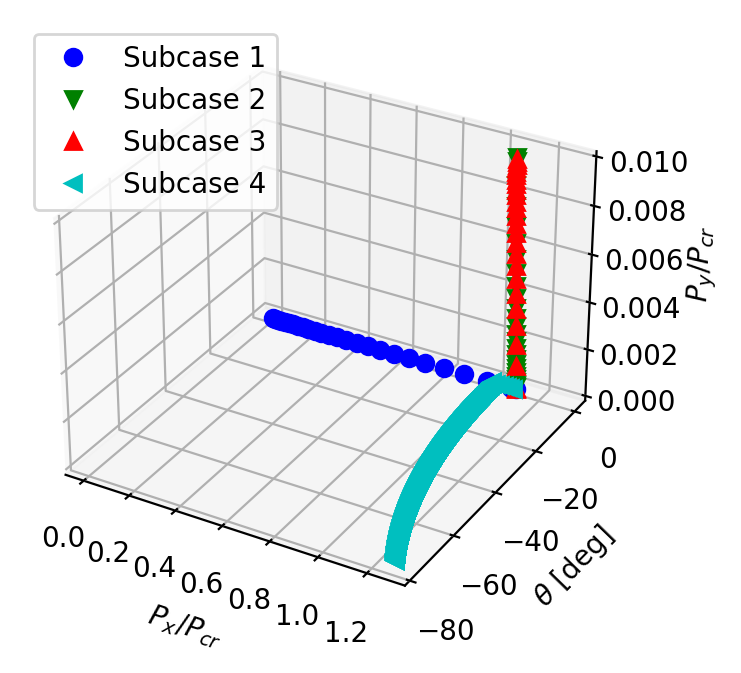

In [323]:
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

We can observe how with the arc-length method there is no jump of $\theta$ with the arc-length method, rather we follow an equilibrium path with slightly negative values of $\theta$. As a consequence, we need to investigate better the equilibrium path around $P_x/P_{cr}=2$.

We copy the previous model object and we choose a name for the new analysis.

In [324]:
exploration_model = model.__deepcopy__({})
exploration_model_name = 'column_pitchfork_bifurcation_exploration'

We define the subcases in the following way.
1. Subcase 1 stays unchanged.
2. In subcase 2 we keep the compression force and apply a large transverse force, setting $P_y/P_{cr}=100$, in order to examine in detail the equilibrium path.
3. In subcase 3 we keep the compression force, remove the transverse force and apply another transverse force with $P_y/P_{cr}=-100$, so equal but in opposite direction with respect to the force applied in subcase 2. In this way we study the other side of the equilibrium path.
4. Subcases 4 and 5 are removed.

We use the same NLPARM and NLPCI cards used previously. Smaller values of MAXALR were also tested, but no significant change in the results was observed.

In [325]:
# Remove subcases from 3 to 5
del exploration_model.subcases[3]
del exploration_model.subcases[4]
del exploration_model.subcases[5]
# Modify magnitude of transverse force
exploration_model.loads[transverse_force_sid][0].mag = euler_buckling_load*100
# Create subcase 3
subcase_id = 3
subtitle = 'Add transverse load in opposite direction'
combined_load_opposite_direction_sid = zero_load_sid+1
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., -1.]
utils.create_column_subcase(exploration_model, subcase_id, subtitle, combined_load_opposite_direction_sid, force_sids, scale_factors)

Let's create the analysis directory, write the bdf file and run the analysis.

In [326]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
run_analysis(analysis_directory_path, exploration_model_name, exploration_model, run_flag=False)

And now let's read the op2 file and visualize the results.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -256.48 degrees
Subcase 3: theta = 256.49 degrees


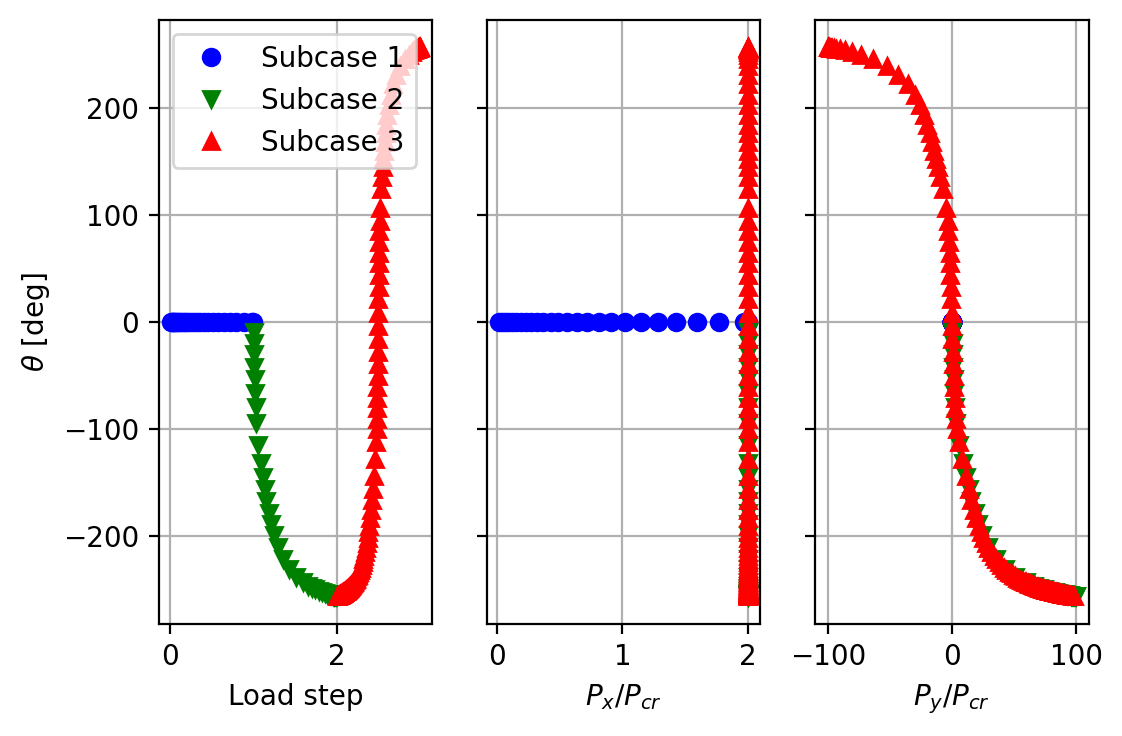

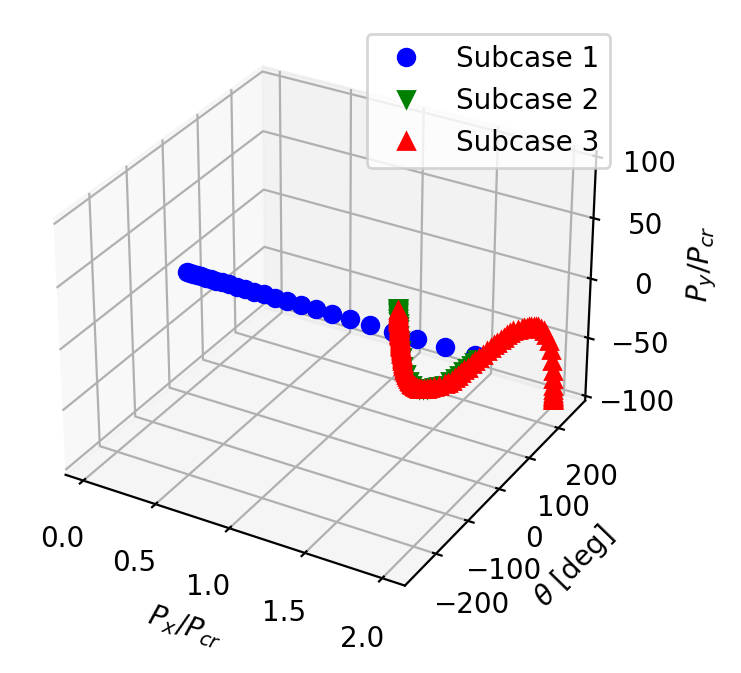

In [327]:
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, exploration_model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

From the results it is clear that the column deflects in the opposite way with respect to the direction of application of the transverse load. Furthermore, the equilibrium path does not seem to justify the jump that we observed with the Newton method.

#### Alternative subcase sequence <a name="alternative-subcase"></a>
Let's try a different sequence of subcases to reproduce the supercritical pitchfork bifurcation with the arc-length method.
1. Apply combined compression and transverse force, setting $P_y/P_{cr}=1/100$. In this way we move along the equilibrium path of the broken pitchfork.
2. Remove the transverse force, in order to switch from the broken pitchfork to curved stable branch of the pristine pitchfork.
3. Remove the compression force, in order to travel the pitchfork bifurcation back to the undeformed state of the structure.
4. Apply compression force only to visualize the unstable branch of the pitchfork.

We proceed with copying the original model and with modifying the subcases.

In [328]:
# Define new name of the model
alternative_subcases_model = model.__deepcopy__({})
alternative_subcases_model_name = 'column_pitchfork_bifurcation_alternative_subcases'
# Modify subcase 1
alternative_subcases_model.subcases[1].params['LOAD'][0] = combined_load_sid
alternative_subcases_model.subcases[1].params['SUBTITLE'][0] = 'Apply compression and transverse load'
# Modify subcase 2
alternative_subcases_model.subcases[2].params['LOAD'][0] = compression_load_sid
alternative_subcases_model.subcases[2].params['SUBTITLE'][0] = 'Remove transverse load'
# Modify subcase 3
alternative_subcases_model.subcases[3].params['LOAD'][0] = zero_load_sid
alternative_subcases_model.subcases[3].params['SUBTITLE'][0] = 'Remove compression load'
# Create subcase 4
alternative_subcases_model.subcases[4].params['LOAD'][0] = compression_load_sid
alternative_subcases_model.subcases[4].params['SUBTITLE'][0] = 'Applly compression load'
# Remove subcase 4
del alternative_subcases_model.subcases[5]

Once again, we create the analysis directory, write the bdf file, run the analysis, read the op2 file and plot the results.

Subcase 1: theta = 51.65 degrees
Subcase 2: theta = 50.38 degrees


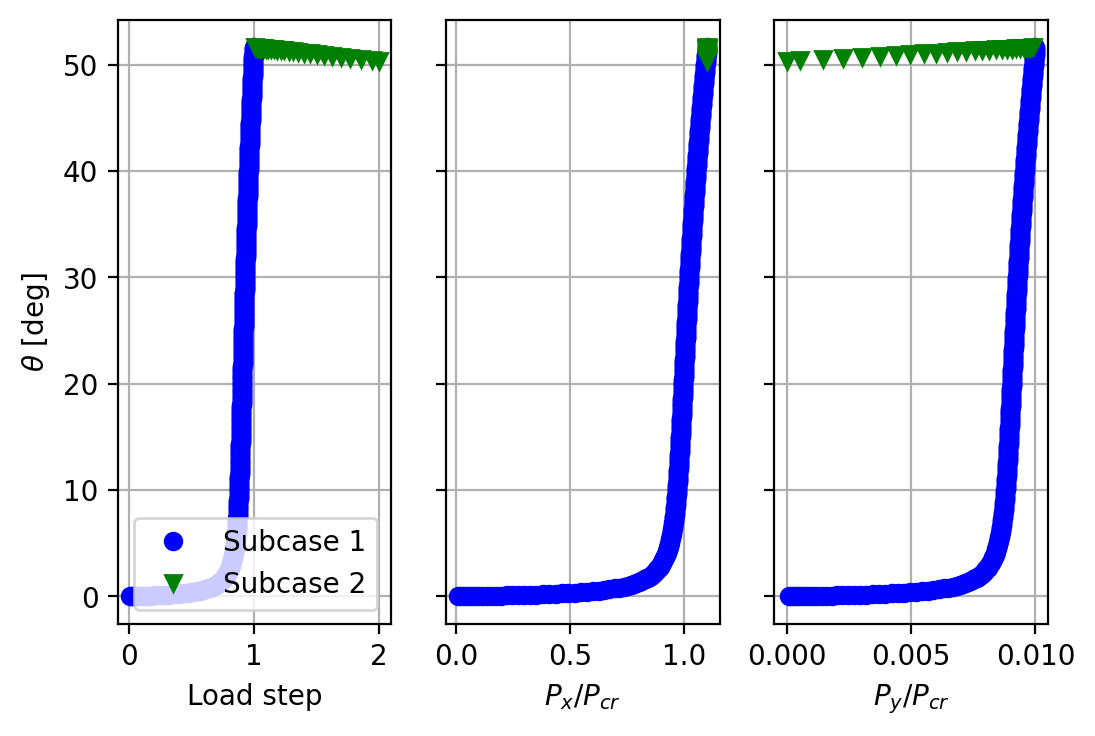

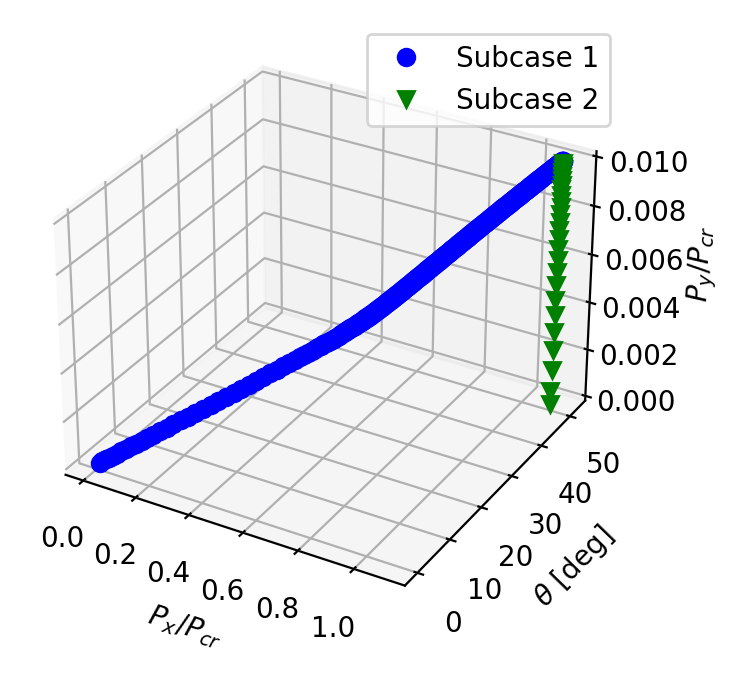

In [329]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
run_analysis(analysis_directory_path, alternative_subcases_model_name, alternative_subcases_model, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, alternative_subcases_model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

The nonlinear analysis does not converge in subcase 2. The negative load step means that the load increment is reduced because of non-convergence issues, at the point that it changes sign. This means that instead of being unloaded from the transverse force, the structure is loaded with a larger transverse force. The analysis stops because the maximum number of increments is reached.

#### Reduced compression force
One possible explanation for the observed results might be that the compression force applied in the analyses is too large and in the consequent deformed shape the material goes beyond the linear elasticity regime. We check whether this is the case reducing the compression force to $P_x/P_{cr}=1.1$ and rerunning both the analyses with standard and alternative subcase sequence.

We first run the analysis for the standard subcase sequence.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -3.51 degrees
Subcase 3: theta = 0.00 degrees
Subcase 4: theta = -76.58 degrees


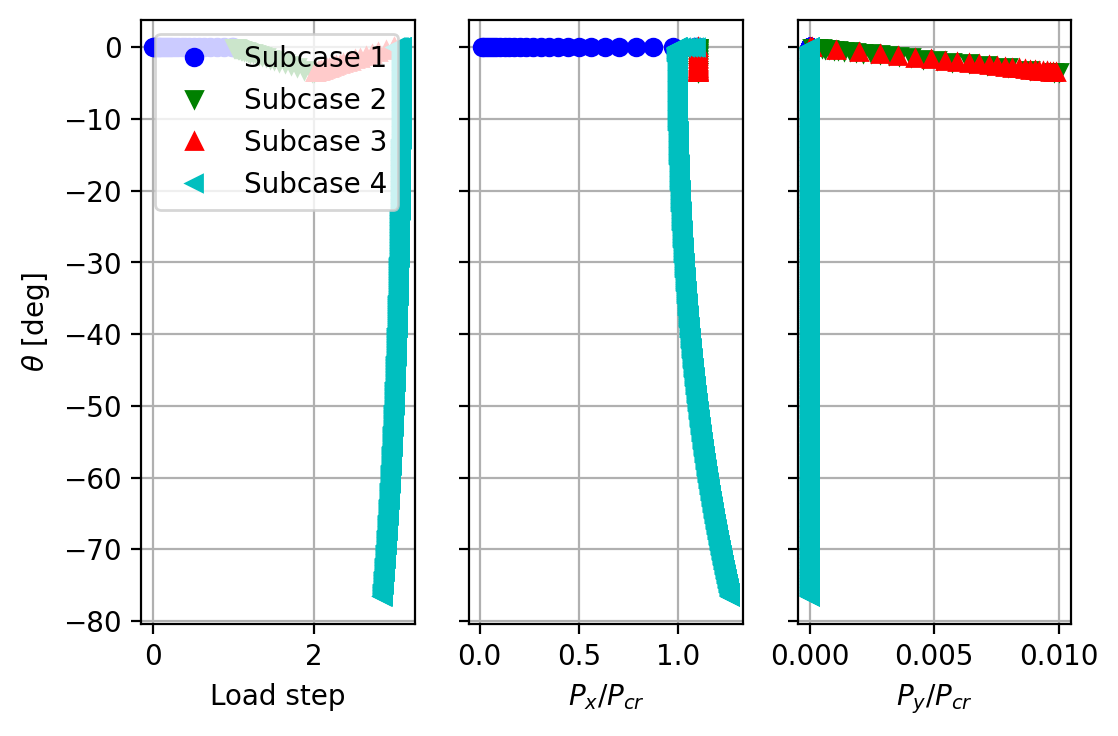

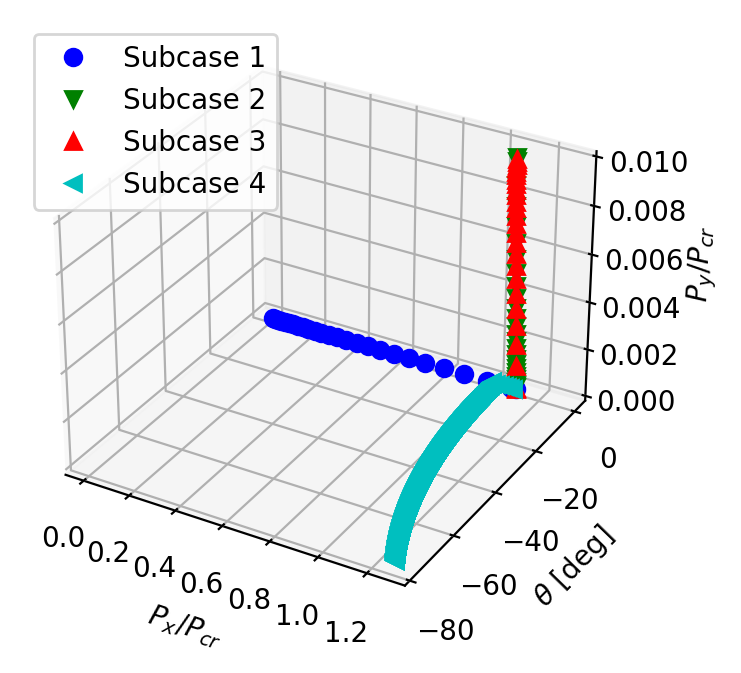

In [330]:
# Modify magnitude of compression force
model.loads[compression_force_sid][0].mag = euler_buckling_load*1.1
# Run analysis
run_analysis(analysis_directory_path, model_name, model, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

The results for subcases 2 and 3 are analogous to the ones obtained earlier with $P_x/P_{cr}=2$. When the transverse force is applied, the solution does not move onto the equilibrium path of the broken pitchfork. Instead, a small negative $\theta$ is found at the end of subcase 2, which indicates a downward deflection of the column for an upward transverse force. When the transverse force is removed in subcase 3 the solution goes back on the unstable branch of the pitchfork. It is interesting to notice that when the compression force is removed in subcase 4, the solution seems to follow the one of the two curved stable branches of the pitchfork. What probably happens is that the arc-length method accidentally selects the stable downward deflection branch and is not able to go back to the flat stable branch. In fact, once on the curved branch, the load is increased instead of being reduced, and the analysis terminates because the maximum number of controlled increments is exceeded.

Now we run the analysis for the alternative subcase sequence.

Subcase 1: theta = 51.65 degrees
Subcase 2: theta = 50.38 degrees


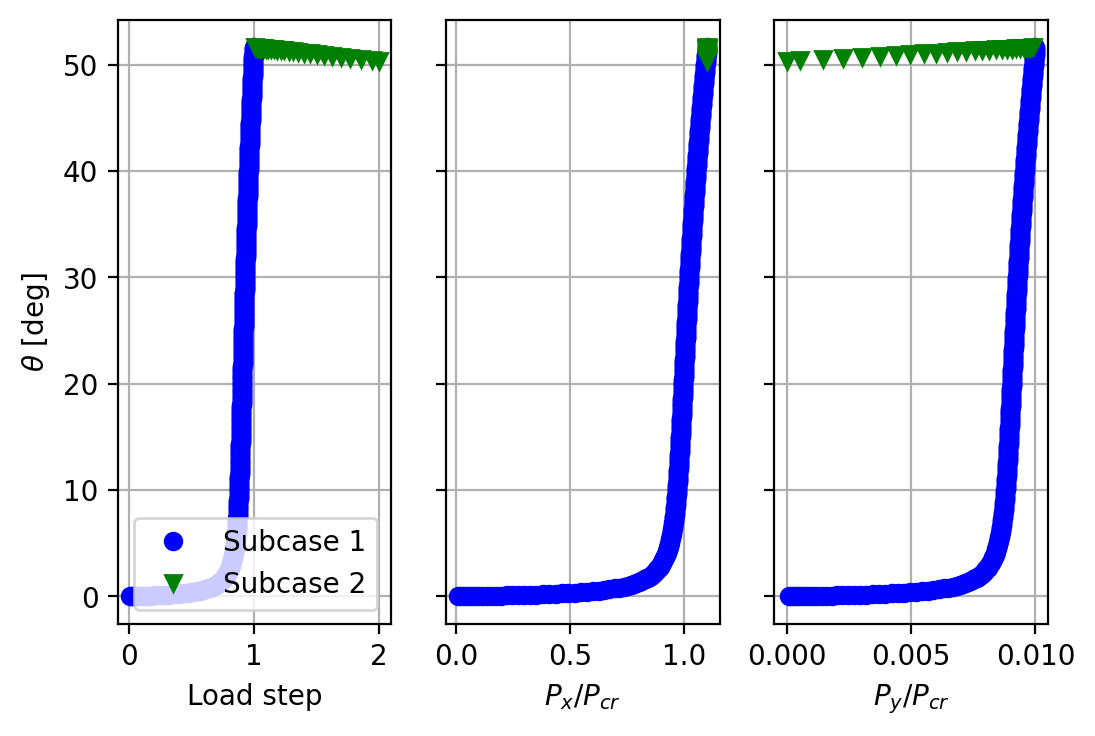

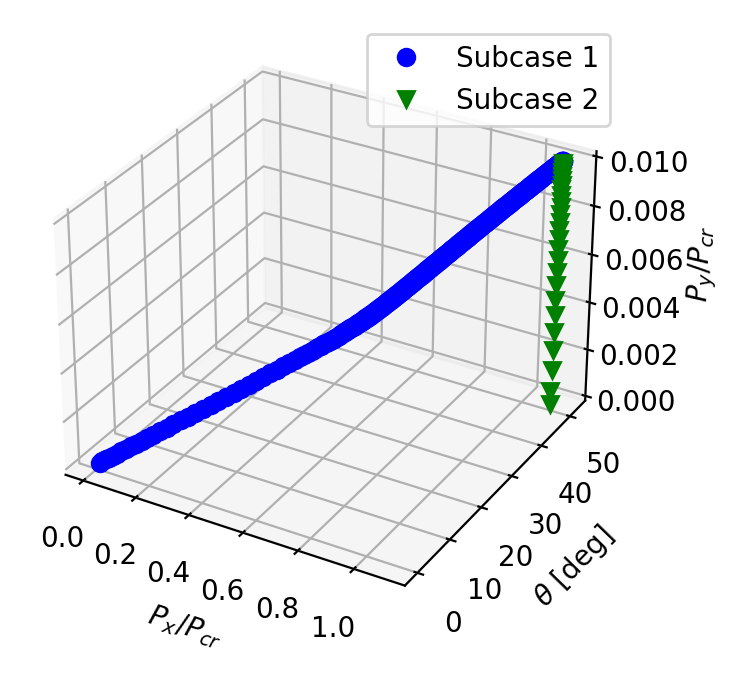

In [331]:
# Modify magnitude of compression force
alternative_subcases_model.loads[compression_force_sid][0].mag = euler_buckling_load*1.1
# Run analysis
run_analysis(analysis_directory_path, alternative_subcases_model_name, alternative_subcases_model, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, alternative_subcases_model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

We can observe that in this case subcase 2 is successfully completed, on the contrary of the case with $P_x/P_{cr}$ where the arc-length method did not manage to remove the transverse load and it had to increase it because of convergence issues. However, subcase 3 fails with the following messages:

 *** USER WARNING MESSAGE 6195 (NLITER)
     SOLUTION HAS REGRESSED TO AN EARLIER LOAD STEP. (BACK-UP COEFFICIENT =-9.998249D-01)
 *** USER FATAL MESSAGE 6196 (NLITER)
     REGRESSION HAS OCCURRED WITH BOTH ROOT-SELECTION ALGORITHMS IN CRISFIELD'S METHOD

### Mixed methods <a name="mixed-methods"></a>
We have observed that the arc-length method seems to encounter issues when forces are unloaded from the structure. For this reason we try to repeat the analysis with the alternative subcase sequence substituting the arc-length method with the full Newton method for subcases 2 and 3.

For this purpose we first add another `NLPARM` card to the model and assign its id to subcases 2 and 3.

In [332]:
mixed_methods_model_name = 'column_pitchfork_bifurcation_mixed_methods'
nlparm2_id = 2
alternative_subcases_model.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
alternative_subcases_model.case_control_deck.subcases[2].add_integer_type('NLPARM', nlparm2_id)
alternative_subcases_model.case_control_deck.subcases[3].add_integer_type('NLPARM', nlparm2_id)

Then we run the analysis and plot the results.

Subcase 1: theta = 51.65 degrees
Subcase 2: theta = 50.38 degrees
Subcase 3: theta = -0.00 degrees
Subcase 4: theta = 0.00 degrees


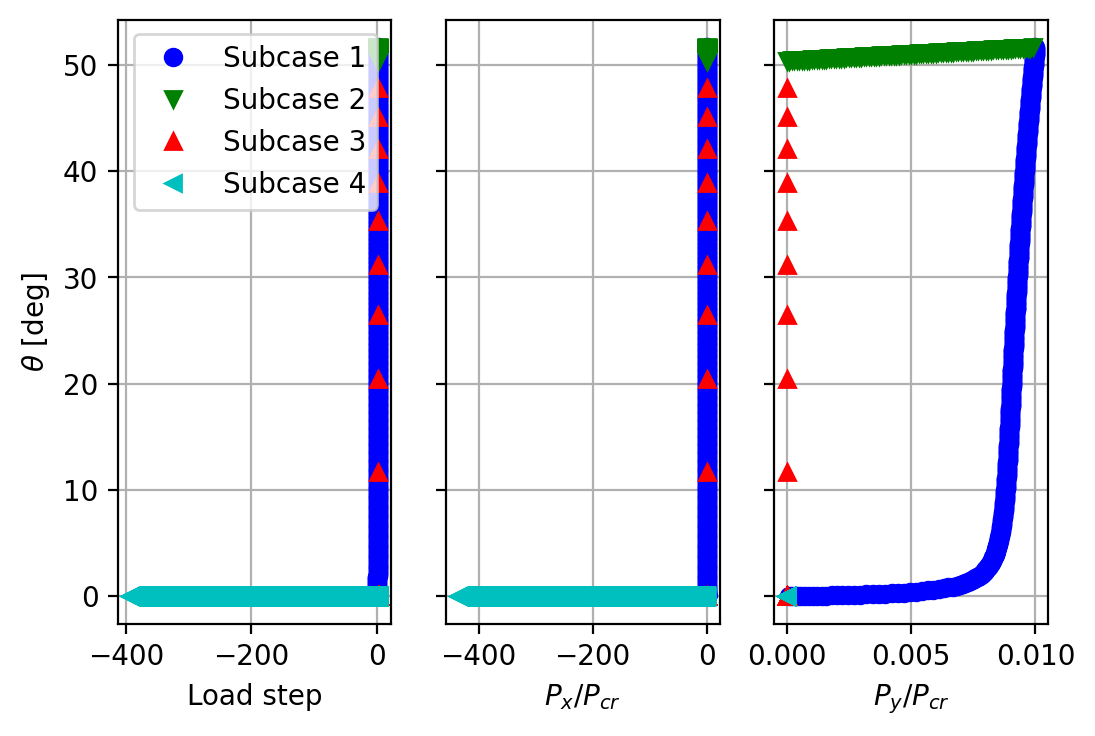

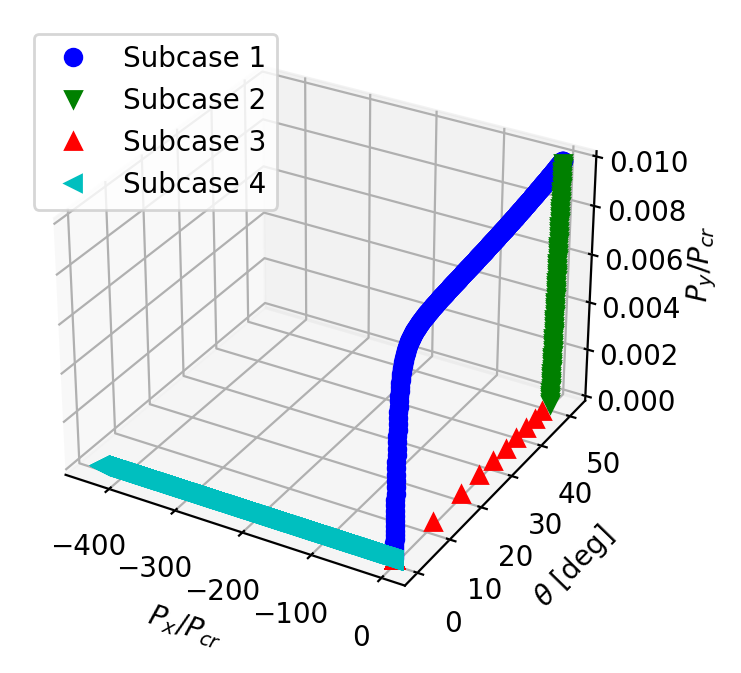

In [333]:
# Run analysis
run_analysis(analysis_directory_path, mixed_methods_model_name, alternative_subcases_model, run_flag=True)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, mixed_methods_model_name + '.op2')
# Get output data from op2 file
load_step, rotation, applied_load_x, applied_load_y = op2_to_output_data(op2_file_path)
# Plot 2d results
plot_2d_paths(rotation, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_paths(rotation, applied_load_x, applied_load_y)

Both subcase 2 and subcase 3 are completed successfully with the Newton method. However, in subcase 4 the arc-length method fails to apply the compressive load. The negative values of load step and $P_x/P_{cr}$ represent the load being applied in the opposite direction, that is to say in extension.

## SOL 400 <a name="arc-length-sol400"></a>
SOL 400 is supposed to have better convergence strategies, so we test the arc-length method with such solution sequence. We use the original loading sequence. Unfortunately, `pyNastran` does not support all the functionalities of SOL 400, in particular the ones needed to define the `STEP` case control commands, which allow us to prescribe the loading sequence, and the `NLSTEP` bulk data entry, which is used to set the arc-length method parameters. As a consequence we set up and run our bdf file manually and we only load the results here.

The parameters used for the arc-length method are reported below for reference:
- maximum number of iterations for each increment: 25
- minimum number of iterations for each increment: 1
- maximum number of bisections in current step: 10
- Crisfield constraint type
- initial time step defined as a fraction of the load step time: 0.01
- minimum allowable arc-length adjustment ratio: 0.01
- convergence criteria: displacement error, load error and vector component method
- error tolerance for displacement criterion: 0.001
- error tolerance for load criterion: 0.001
- pure full Newton iteration method

Let's read the op2 file and plot the results.

Step 1: theta = 0.00 degrees
Step 2: theta = -0.38 degrees
Step 3: theta = -0.00 degrees
Step 4: theta = -0.00 degrees
Step 5: theta = 124.34 degrees


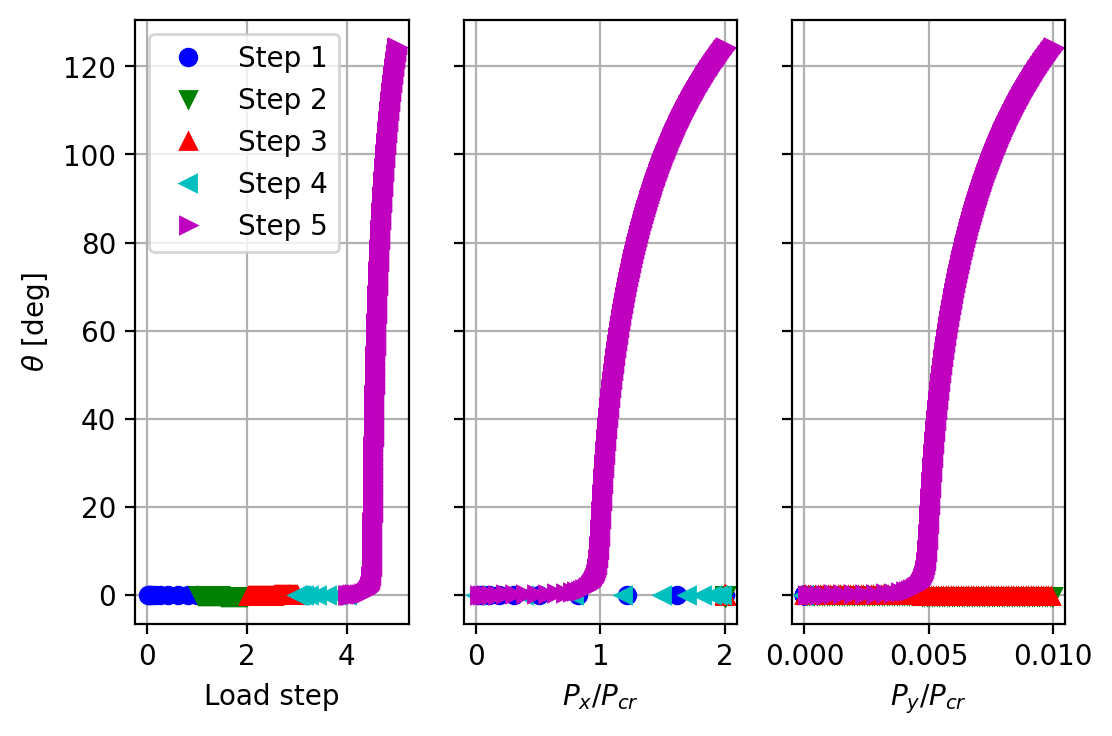

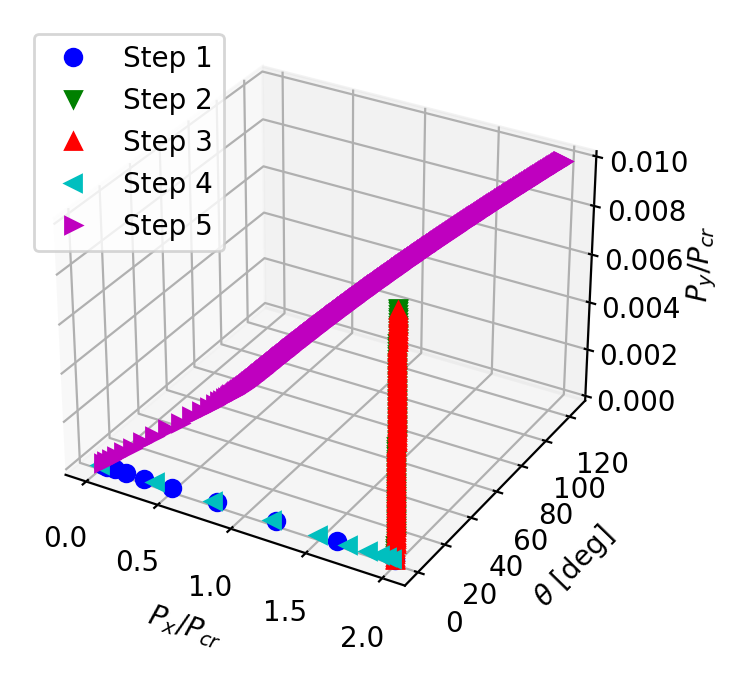

In [334]:
# Read op2 file
op2_file_path = os.path.join(analysis_directory_path, 'kb8021539_pitchfork_bifurcation_arclength.op2')
op2 = read_op2(op2_file_path, build_dataframe=True, debug=False)
# Store applied load and rotation at the pin-supported node
steps = list(range(6))
applied_load = {}
rotation = {}
load_step = {}
for step in steps[0:-1]:
    indices = [idx for idx, val in enumerate(op2.load_vectors[1].lftsfqs) if step < val <= step + 1]
    applied_load_x[step+1] = -np.apply_along_axis(np.sum, 1, op2.load_vectors[1].data[indices, :, 0])
    applied_load_y[step+1] = np.apply_along_axis(np.sum, 1, op2.load_vectors[1].data[indices, :, 1])
    rotation[step+1] = np.rad2deg(op2.displacements[1].data[indices, 1, 5])
    load_step[step+1] = [op2.load_vectors[1].lftsfqs[i] for i in indices]

# Set plotting style for different subcases
style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m'}
# Create figure with 2D subplots
fig, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
for key in rotation:
    # Print rotation at the end of subcase
    print(f'Step {key:d}: theta = {rotation[key][-1]:.2f} degrees')
    # Plot load step vs rotation
    axs[0].plot(load_step[key], rotation[key], style[key], label='Step {:d}'.format(key))
    # Plot applied load along x vs rotation
    axs[1].plot(applied_load_x[key]/euler_buckling_load, rotation[key], style[key], label='Step {:d}'.format(key))
    # Plot applied load along y vs rotation
    axs[2].plot(applied_load_y[key]/euler_buckling_load, rotation[key], style[key], label='Step {:d}'.format(key))
# Set plot appearance
axs[0].set_xlabel('Load step')
axs[0].set_ylabel('$\\theta$ [deg]')
axs[0].grid(visible=True)
axs[1].set_xlabel('$P_x/P_{cr}$')
axs[1].grid(visible=True)
axs[2].set_xlabel('$P_y/P_{cr}$')
axs[2].grid(visible=True)
axs[0].legend()
# Show plot
plt.show()

# Create figure with three-dimensional axes
fig = plt.figure()
ax = plt.axes(projection='3d')
for subcase_id in rotation:
    # Plot load applied along x vs rotation of pin-supported node vs applied along y
    ax.plot3D(applied_load_x[subcase_id]/euler_buckling_load, rotation[subcase_id], applied_load_y[subcase_id]/euler_buckling_load, style[subcase_id], label='Step {:d}'.format(subcase_id))
ax.set_xlabel('$P_x/P_{cr}$')
ax.set_ylabel('$\\theta$ [deg]')
ax.set_zlabel('$P_y/P_{cr}$')
ax.legend()
ax.grid(visible=True)
plt.show()

The results correspond to the ones obtained with SOL 106. Furthermore, when using the alternative load sequence the analysis does not converge in an analogous way as observed with SOL 106.